In [39]:
from eval_utils import *
from data.data_loader import *
import ast
import os
import copy
import matplotlib.pyplot as plt
from google import genai
from google.genai import types
import tqdm
import json
import time
import pandas as pd
import numpy as np

PROJECT_ROOT = "/Users/satoshinakamoto/Documents/education/mcgill_cs_2023/2025_FALL/comp545/project/code/visual-cot"
os.chdir(PROJECT_ROOT)

full_dataset = data_loader()

In [ ]:
# Setting API
client = genai.Client(api_key=key)

# Setting model
MODEL = "gemini-2.5-pro"


# Testing API
# A list of dictionaries, where each is a GenerateContentRequest
inline_requests = [
    {
        'contents': [{
            'parts': [{'text': 'Tell me a one-sentence joke.'}],
            'role': 'user'
        }]
    },
    {
        'contents': [{
            'parts': [{'text': 'Why is the sky blue?'}],
            'role': 'user'
        }]
    }
]

inline_batch_job = client.batches.create(
    model=MODEL,
    src=inline_requests,
    config={
        'display_name': "inlined-requests-job-1",
    },
)

print(f"Created batch job: {inline_batch_job.name}")

Created batch job: batches/g3n4s6ibgtph419vx6yl11f6bmqcxol31qh6


In [28]:
# Created batch job: batches/fu1r499snpbml7kftpgxr1wgrmu91xuqzq2y

job_name = inline_batch_job.name
print(f"Polling status for job: {job_name}")

while True:
    batch_job_inline = client.batches.get(name=job_name)
    if batch_job_inline.state.name in ('JOB_STATE_SUCCEEDED', 'JOB_STATE_FAILED', 'JOB_STATE_CANCELLED', 'JOB_STATE_EXPIRED'):
        break
    print(f"Job not finished. Current state: {batch_job_inline.state.name}. Waiting 30 seconds...")
    time.sleep(30)

print(f"Job finished with state: {batch_job_inline.state.name}")

# print the response
for i, inline_response in enumerate(batch_job_inline.dest.inlined_responses, start=1):
    print(f"\n--- Response {i} ---")

    # Check for a successful response
    if inline_response.response:
        # The .text property is a shortcut to the generated text.
        print(inline_response.response.text)

Polling status for job: batches/fu1r499snpbml7kftpgxr1wgrmu91xuqzq2y
Job finished with state: JOB_STATE_SUCCEEDED

--- Response 1 ---
I'm reading a book on anti-gravity, and it's impossible to put down.

--- Response 2 ---
Of course! This is a fantastic question. The short answer is:

**The sky is blue because of the way Earth's atmosphere scatters sunlight.**

Here’s a more detailed, step-by-step explanation.

### 1. Sunlight Isn't Just White

First, it's important to know that the light coming from the sun, which we see as white light, is actually made up of all the colors of the rainbow (Red, Orange, Yellow, Green, Blue, Indigo, Violet). You can see this when light passes through a prism or in a rainbow.

Each of these colors travels as a wave, and each color has a different wavelength.
*   **Red light** has a long wavelength.
*   **Blue and violet light** have very short wavelengths.



### 2. The Atmosphere Gets in the Way

As sunlight travels to Earth, it hits our atmosphere, whi

## EXPERIMENT: GEMINI 2.5 PRO WITH FEW SHOTS PROMPTING 

In [12]:
IDS_TO_TEST_PATH = "./eval/results/gemini/few_shots/ids_to_test.json"
FSP_EXAMPLES = "./eval/results/gemini/few_shots/fsp_examples.json"
RESPONSES_PATH = "./eval/results/gemini/few_shots/responses.jsonl"
REQUESTS_PATH = "./eval/results/gemini/few_shots/requests.jsonl"

In [74]:
full_dataset = data_loader()


# Verify if few shots prompting examples have indeed the right solution

with open(FSP_EXAMPLES, "r") as f:
    raw = json.load(f)
    fsp_ex = {int(k): v for k, v in raw.items()}

for pid in fsp_ex:
    puzzle = copy.deepcopy(full_dataset[pid])
    solution = fsp_ex[pid]['solution']
    
    completed_moves, success, error = eval_sol(puzzle, solution)
    print(completed_moves, success, error)


5 True None
10 True None
20 True None


In [ ]:
# Helper function
def board_to_prompt(board):
    # Format the board into string representation
    formatted = []
    for row in board:
        new_row = []
        for cell in row:
            if cell is None:
                new_row.append('.')
            else:
                new_row.append(str(cell))
        formatted.append(new_row)

    # Create compact single-quote format for LLM prompt
    board_str = "[ " + ", ".join(
        ["['" + "','".join(row) + "']" for row in formatted]
    ) + " ]"

    return board_str

def create_prompt(exit, board, fsp_ex_array):

    prompt = f'''You have to solve a 6x6 rush hour puzzle.
Your goal is to move the Red car out. 
On the board, 'R' designates the Red car. 
The exit is located at {exit}.
Here are some few examples. 

Example 1) 
Input: {fsp_ex_array[0][0]}
Output: {fsp_ex_array[0][1]}

Example 2) 
Input: {fsp_ex_array[1][0]}
Output: {fsp_ex_array[1][1]}

Example 3) 
Input: {fsp_ex_array[2][0]}
Output: {fsp_ex_array[2][1]}
                
The following puzzle is the one you have to solve:
Input: {board}
Remember that the exit is located at {exit} and that you have to move the 'R' car.
Provide only the text response with no bolding or formatting and do not include the word "Output:"'''
    
    return prompt

In [90]:
# Build array with fsp examples, used later by create_prompt function

fsp_ex_array = []

for pid in fsp_ex:
    puzzle = fsp_ex[pid]
    fsp_ex_array.append([board_to_prompt(puzzle['board']), puzzle['solution']])

print(fsp_ex_array)

[["[ ['B','B','C','C','C','.'], ['.','.','.','G','.','.'], ['R','R','.','G','.','.'], ['.','F','D','D','D','.'], ['.','F','.','.','.','.'], ['E','E','E','.','.','.'] ]", [{'name': 'E', 'direction': 'right', 'distance': 2}, {'name': 'F', 'direction': 'down', 'distance': 1}, {'name': 'D', 'direction': 'left', 'distance': 2}, {'name': 'G', 'direction': 'down', 'distance': 2}, {'name': 'R', 'direction': 'right', 'distance': 4}]], ["[ ['B','B','B','C','C','J'], ['.','.','.','.','.','J'], ['.','.','R','R','.','J'], ['.','.','.','I','D','D'], ['E','E','E','I','F','F'], ['.','G','G','H','H','H'] ]", [{'name': 'R', 'direction': 'left', 'distance': 1}, {'name': 'I', 'direction': 'up', 'distance': 2}, {'name': 'F', 'direction': 'left', 'distance': 1}, {'name': 'D', 'direction': 'left', 'distance': 1}, {'name': 'G', 'direction': 'left', 'distance': 1}, {'name': 'H', 'direction': 'left', 'distance': 1}, {'name': 'J', 'direction': 'down', 'distance': 3}, {'name': 'C', 'direction': 'right', 'distance

In [92]:
test_puzzle = full_dataset[2]
test_prompt = create_prompt(test_puzzle['exit'], board_to_prompt(test_puzzle['board']), fsp_ex_array)
print(test_prompt)

You have to solve a 6x6 rush hour puzzle.
Your goal is to move the Red car out. 
On the board, 'R' designates the Red car. 
The exit is located at [3, 6].
Here are some few examples. 

Example 1) 
Input: [ ['B','B','C','C','C','.'], ['.','.','.','G','.','.'], ['R','R','.','G','.','.'], ['.','F','D','D','D','.'], ['.','F','.','.','.','.'], ['E','E','E','.','.','.'] ]
Output: [{'name': 'E', 'direction': 'right', 'distance': 2}, {'name': 'F', 'direction': 'down', 'distance': 1}, {'name': 'D', 'direction': 'left', 'distance': 2}, {'name': 'G', 'direction': 'down', 'distance': 2}, {'name': 'R', 'direction': 'right', 'distance': 4}]

Example 2) 
Input: [ ['B','B','B','C','C','J'], ['.','.','.','.','.','J'], ['.','.','R','R','.','J'], ['.','.','.','I','D','D'], ['E','E','E','I','F','F'], ['.','G','G','H','H','H'] ]
Output: [{'name': 'R', 'direction': 'left', 'distance': 1}, {'name': 'I', 'direction': 'up', 'distance': 2}, {'name': 'F', 'direction': 'left', 'distance': 1}, {'name': 'D', 'direc

In [78]:
# Load ids of puzzles that have to be tested

with open(IDS_TO_TEST_PATH, "r") as f:
    raw = json.load(f)
    ids_test = {int(k): v for k, v in raw.items()}
print(ids_test)

{3: [25, 21, 18, 28, 27, 15, 14, 19, 24, 30], 4: [36, 46, 45, 41, 58, 37, 43, 56, 51, 49], 5: [59, 80, 64, 67, 66, 81, 75, 82, 73, 72], 6: [95, 94, 96, 92, 102, 97, 84, 83, 98, 86], 7: [116, 114, 107, 120, 112, 108, 124, 128, 127, 123], 8: [154, 138, 140, 142, 149, 152, 137, 150, 147, 132], 9: [177, 167, 156, 162, 176, 161, 159, 166, 173, 157], 10: [193, 185, 179, 202, 184, 183, 201, 200, 197, 189], 11: [222, 210, 205, 209, 213, 224, 207, 216, 211, 226], 12: [231, 239, 227, 248, 232, 240, 233, 241, 244, 247], 13: [263, 251, 255, 253, 269, 259, 270, 258, 260, 261], 14: [280, 279, 294, 286, 284, 283, 285, 297, 293, 288], 15: [309, 302, 301, 311, 319, 315, 318, 306, 313, 322], 16: [323, 327, 340, 339, 341, 336, 343, 346, 331, 334], 17: [354, 352, 360, 353, 363, 364, 358, 370, 365, 350], 18: [386, 394, 392, 377, 381, 378, 389, 383, 384, 379], 19: [418, 398, 404, 412, 409, 417, 406, 401, 402, 413], 20: [429, 425, 440, 426, 427, 433, 421, 434, 428, 422]}


In [85]:
board_str = board_to_prompt(test_puzzle["board"])
print(board_str)
print(test_puzzle["board"])

[ ['.','.','.','.','.','.'], ['.','.','.','.','.','B'], ['R','R','.','.','.','B'], ['.','.','.','.','.','.'], ['.','.','.','.','.','.'], ['.','.','.','.','.','.'] ]
[[None, None, None, None, None, None], [None, None, None, None, None, 'B'], ['R', 'R', None, None, None, 'B'], [None, None, None, None, None, None], [None, None, None, None, None, None], [None, None, None, None, None, None]]


In [105]:
def create_request(REQUESTS_PATH, pid, prompt_text):

    req = {
        "key": str(pid),
        "request": {
            "contents": [
                {
                    "parts": [
                        {"text": prompt_text}
                    ]
                }
            ]
        }
    }

    # append mode so each request becomes a new line
    with open(REQUESTS_PATH, "a") as f:
        f.write(json.dumps(req) + "\n")


In [102]:
for level in ids_test:
    for pid in ids_test[level]:
        puzzle = full_dataset[pid]
        prompt_text = create_prompt(puzzle['exit'], board_to_prompt(puzzle['board']), fsp_ex_array)
        create_request(REQUESTS_PATH, pid, prompt_text)

In [103]:
# Upload the file to the File API
uploaded_file = client.files.upload(
    file=REQUESTS_PATH,
    config=types.UploadFileConfig(display_name='requests_fsp_gemini_2.5_pro', mime_type='jsonl')
)

print(f"Uploaded file: {uploaded_file.name}")

Uploaded file: files/fgi2nac5rty6


In [104]:
# Uploaded file: files/3w448jf8w6tn

file_batch_job = client.batches.create(
    model=MODEL,
    src=uploaded_file.name,
    config={
        'display_name': "file-upload-job-1",
    },
)

print(f"Created batch job: {file_batch_job.name}")

Created batch job: batches/n0gew9716x3i1gjzwsim011o4ufr46zhctkz


In [109]:
# Created batch job: batches/n0gew9716x3i1gjzwsim011o4ufr46zhctkz

job_name = file_batch_job.name
print(f"Polling status for job: {job_name}")

while True:
    batch_job_inline = client.batches.get(name=job_name)
    if batch_job_inline.state.name in ('JOB_STATE_SUCCEEDED', 'JOB_STATE_FAILED', 'JOB_STATE_CANCELLED', 'JOB_STATE_EXPIRED'):
        break
    print(f"Job not finished. Current state: {batch_job_inline.state.name}. Waiting 60 seconds...")
    time.sleep(60)

print(f"Job finished with state: {batch_job_inline.state.name}")

Polling status for job: batches/n0gew9716x3i1gjzwsim011o4ufr46zhctkz
Job not finished. Current state: JOB_STATE_RUNNING. Waiting 60 seconds...
Job not finished. Current state: JOB_STATE_RUNNING. Waiting 60 seconds...
Job not finished. Current state: JOB_STATE_RUNNING. Waiting 60 seconds...
Job not finished. Current state: JOB_STATE_RUNNING. Waiting 60 seconds...
Job not finished. Current state: JOB_STATE_RUNNING. Waiting 60 seconds...
Job not finished. Current state: JOB_STATE_RUNNING. Waiting 60 seconds...
Job not finished. Current state: JOB_STATE_RUNNING. Waiting 60 seconds...
Job not finished. Current state: JOB_STATE_RUNNING. Waiting 60 seconds...
Job finished with state: JOB_STATE_SUCCEEDED


In [49]:
# Save the job output to file
# batches/n0gew9716x3i1gjzwsim011o4ufr46zhctkz
job_name = "batches/n0gew9716x3i1gjzwsim011o4ufr46zhctkz"
batch_job = client.batches.get(name=job_name)

if batch_job.state.name == 'JOB_STATE_SUCCEEDED':

    # If batch job was created with a file
    if batch_job.dest and batch_job.dest.file_name:
        
        result_file_name = batch_job.dest.file_name
        
        file_content = client.files.download(file=result_file_name)
        
        with open(RESPONSES_PATH, "w") as f:
            f.write(file_content.decode('utf-8'))

        print(f"\nSaved batch output to {RESPONSES_PATH}\n")

    else:
        print("No response file found.")
else:
    print(f"Job did not succeed. Final state: {batch_job.state.name}")
    if batch_job.error:
        print(f"Error: {batch_job.error}")


Saved batch output to ./eval/results/gemini/few_shots/responses.jsonl



In [13]:
responses = []
with open(RESPONSES_PATH, "r") as f:
    for line in f:
        if line.strip():
            obj = json.loads(line)
            responses.append(obj)

print(responses[0])

{'response': {'responseId': 'jmUmaaylLoWN_PUPsfqdwAg', 'candidates': [{'content': {'parts': [{'text': "[{'name': 'B', 'direction': 'left', 'distance': 1}, {'name': 'C', 'direction': 'down', 'distance': 3}, {'name': 'R', 'direction': 'right', 'distance': 4}]"}], 'role': 'model'}, 'index': 0, 'finishReason': 'STOP'}], 'modelVersion': 'gemini-2.5-pro', 'usageMetadata': {'promptTokenCount': 1049, 'promptTokensDetails': [{'tokenCount': 1049, 'modality': 'TEXT'}], 'totalTokenCount': 5818, 'thoughtsTokenCount': 4714, 'candidatesTokenCount': 55}}, 'key': '25'}


In [ ]:
results = {}

for resp in responses:
    pid = int(resp['key'])
    results[pid] = {}
    results[pid]['level'] = full_dataset[pid]['min_moves']
    results[pid]['board'] = full_dataset[pid]['board']
    answer = resp["response"]["candidates"][0]["content"]["parts"][0]["text"]
    
    
    try:
        answer = ast.literal_eval(answer)
        results[pid]['answer'] = answer
        results[pid]['answer_length'] = len(answer)
    except: 
        print(f"Error parsing answer for puzzle ID {pid}: {answer}")
        raise Exception("Parsing error")
    
    results[pid]['completed_moves'], results[pid]['success'], results[pid]['error'] = eval_sol(copy.deepcopy(full_dataset[pid]), answer)
    results[pid]['thoughtsTokenCount'] = resp['response']['usageMetadata']['thoughtsTokenCount']
    


print(results)


{25: {'level': 3, 'board': [[None, None, None, None, None, 'C'], [None, None, None, None, None, 'C'], ['R', 'R', None, None, None, 'C'], [None, None, None, None, 'B', 'B'], [None, None, None, None, None, None], [None, None, None, None, None, None]], 'answer': [{'name': 'B', 'direction': 'left', 'distance': 1}, {'name': 'C', 'direction': 'down', 'distance': 3}, {'name': 'R', 'direction': 'right', 'distance': 4}], 'answer_length': 3, 'completed_moves': 3, 'success': True, 'error': None, 'thoughtsTokenCount': 4714}, 21: {'level': 3, 'board': [[None, 'B', 'B', 'B', None, None], [None, None, None, 'D', None, None], ['R', 'R', None, 'D', None, None], [None, None, 'C', 'C', None, None], [None, None, None, None, None, None], [None, None, None, None, None, None]], 'answer': [{'name': 'C', 'direction': 'left', 'distance': 1}, {'name': 'D', 'direction': 'down', 'distance': 2}, {'name': 'R', 'direction': 'right', 'distance': 4}], 'answer_length': 3, 'completed_moves': 3, 'success': True, 'error': 

In [51]:
# Organize results in a dataframe
df = pd.DataFrame.from_dict(results, orient='index').reset_index()
df = df.rename(columns={'index': 'pid'})

RESULTS_PATH = "./eval/results/gemini/few_shots/results.json"

# Save results to a file
df.to_json(RESULTS_PATH, orient="records", indent=2)



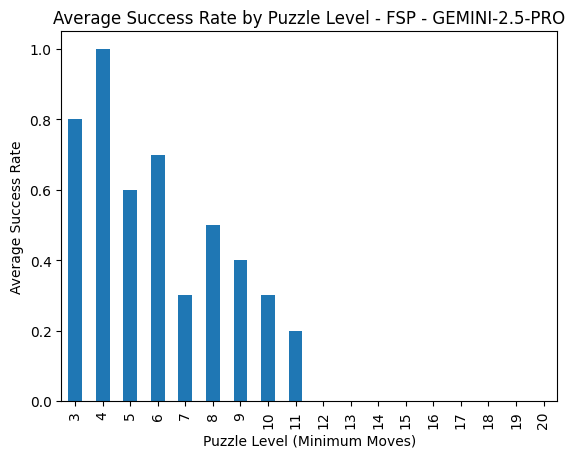

In [45]:
# Graph of average success rate by level
avg_success_by_level = df.groupby('level')['success'].mean()
plt.figure()
avg_success_by_level.plot(kind='bar')
plt.title(f'Average Success Rate by Puzzle Level - FSP - {MODEL.upper()}')
plt.xlabel('Puzzle Level (Minimum Moves)')
plt.ylabel('Average Success Rate')
plt.show()

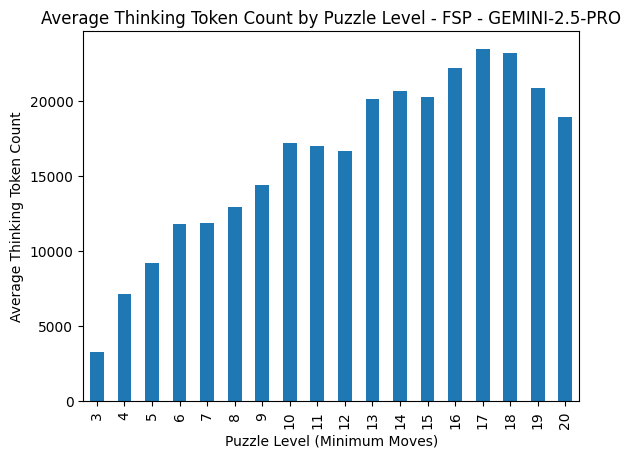

In [44]:
# Graph of average thinking token count by level
avg_thinking_by_level = df.groupby('level')['thoughtsTokenCount'].mean()
plt.figure()
avg_thinking_by_level.plot(kind='bar')
plt.title(f'Average Thinking Token Count by Puzzle Level - FSP - {MODEL.upper()}')
plt.xlabel('Puzzle Level (Minimum Moves)')
plt.ylabel('Average Thinking Token Count')
plt.show()

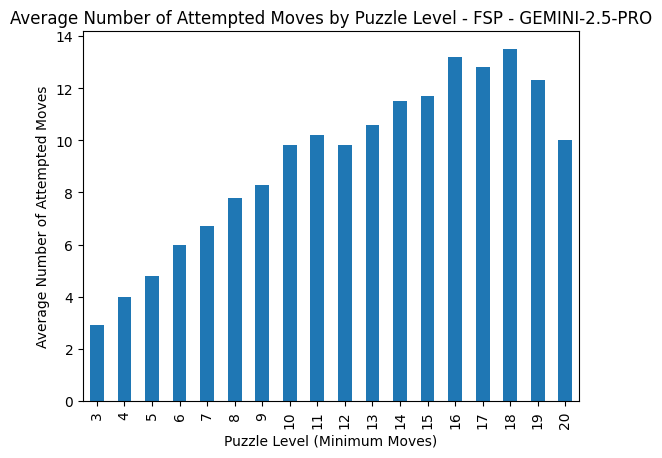

In [43]:
# Graph of average of number of attempted moves per level
avg_moves_by_level = df.groupby('level')['answer_length'].mean()
plt.figure()
avg_moves_by_level.plot(kind='bar')
plt.title(f'Average Number of Attempted Moves by Puzzle Level - FSP - {MODEL.upper()}')
plt.xlabel('Puzzle Level (Minimum Moves)')
plt.ylabel('Average Number of Attempted Moves')
plt.show()

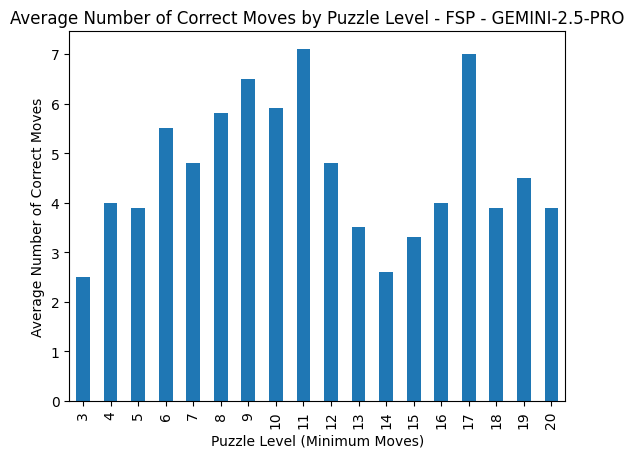

In [42]:
# Average number of correct moves per level
avg_correct_moves_by_level = df.groupby('level')['completed_moves'].mean()
plt.figure()
avg_correct_moves_by_level.plot(kind='bar')
plt.title(f'Average Number of Correct Moves by Puzzle Level - FSP - {MODEL.upper()}')
plt.xlabel('Puzzle Level (Minimum Moves)')
plt.ylabel('Average Number of Correct Moves')
plt.show()


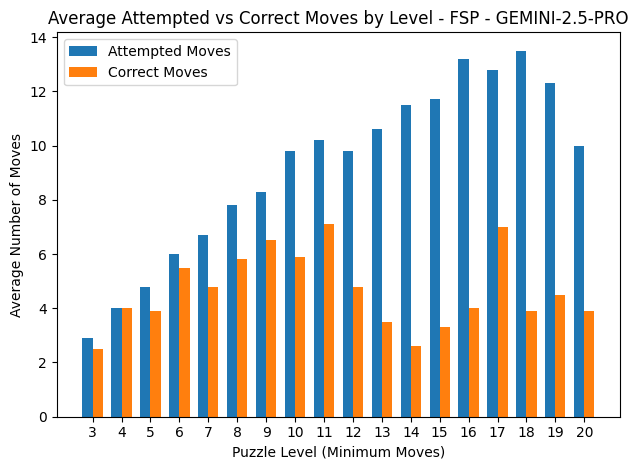

In [ ]:
# Comparison graph of average attempted moves vs correct moves by level
plt.figure()
avg_moves_by_level = df.groupby('level')['answer_length'].mean()
avg_correct_moves_by_level = df.groupby('level')['completed_moves'].mean()

levels = avg_moves_by_level.index

width = 0.35  # width of each bar
x = np.arange(len(levels))

plt.bar(x - width/2, avg_moves_by_level, width, label='Attempted Moves')
plt.bar(x + width/2, avg_correct_moves_by_level, width, label='Correct Moves')

plt.title(f'Average Attempted vs Correct Moves by Level - FSP - {MODEL.upper()}')
plt.xlabel('Puzzle Level (Minimum Moves)')
plt.ylabel('Average Number of Moves')
plt.xticks(x, levels)
plt.legend()
plt.tight_layout()
plt.show()
